# Coursework 2: Generative Models

#### Instructions

Please submit on CATe a zip file named *CW2.zip* containing the following:
1. A version of this notebook containing your answers. Write your answers in the cells below each question.
2. Your trained models as *VAE_model.pth, DCGAN_model_D.pth, DCGAN_model_G.pth*

#### Working environment:

Similarly to the previous coursework, we recommend that you use Google Colaboratory in order to train the required networks.

**The deadline for submission is 19:00, Thursday 27th February, 2020**

### Setting up working environment

For this coursework you, will need to train a large network, therefore we recommend you work with Google Colaboratory, which provides free GPU time. You will need a Google account to do so.

Please log in to your account and go to the following page: https://colab.research.google.com. Then upload this notebook.

For GPU support, go to "Edit" -> "Notebook Settings", and select "Hardware accelerator" as "GPU".

You will need to install pytorch by running the following cell:

In [ ]:
!pip install torch torchvision

## Introduction

For this coursework, you are asked to implement two commonly used generative models:
1. A **Variational Autoencoder (VAE)**
2. A **Deep Convolutional Generative Adversarial Network (DCGAN)**

For the first part you will the MNIST dataset https://en.wikipedia.org/wiki/MNIST_database and for the second the CIFAR-10 (https://www.cs.toronto.edu/~kriz/cifar.html).

## Part 1 (50 points)
1. For the first part, you are asked to implement a Variational Autoencoder on the MNIST dataset. You will be assesed by the following:
    - **loss function and proper explanations**. You will have to choose the right loss function by properly modelling the probability distributions involved. There are more than one accepted approaches. 
    - **reconstruction error**. You will need to achieve a low enough error in order to reconstruct the images of the dataset with relatively high fidelity. You will have to provide us with your best model's training and test loss curves (both the total loss and each individual term), a few reconstructed images and a few sampled images from the latent space of the VAE in the respective cells.
    - **qualitative results**. You have to provide us with certain qualitative results that are usually used to assess the quality of the learned representations (more info below)

 
## Part 2 (50 points)
2. For the DCGAN, The success of your models will be tested as follows:
    - **By the model's training error**. You will need to achieve relatively balanced errors for the generator and the discriminator of your model in order to sample realistic images from the generator. You will have to provide us with your best model's training losses curves, a discussion on how you concluded to the chosen architecture, and visualizations of generated samples in the respective cells. Your results do not have to be perfect, however a good discussion on the choice of architecture will be valued.
    - **By avoiding mode collapse**. A common problem of training GANs is that they end up generating only a few different samples (if not only one), rather than learning the whole distribution of the training data. This problem is referred to as mode collapse. You will need to make a discussion on whether you noticed mode collapse or not during your experimentation and if yes, how you addressed it.

# Part 1 - Variational Autoencoder

## Part 1.1 (25 points)
**Your Task:**

a. Implement the VAE architecture. You are free to choose either Multilayer Perceptrons (MLPs) or Convolutional Layers

You will need to define:
*  The hyperparameters
* The constructor
* encode
* reparametrize
* decode
* forward

b. Design an appropriate loss function. There are multiple accepted solutions. Explain your design choices based on the assumptions you make regarding the distribution of your data.

* Hint: this refers to the log likelihood as mentioned in the tutorial. Make sure these assumptions reflect on the values of your input data, i.e. depending on your choice you might need to do a simple preprocessing step.

* You are encouraged to experiment with the weighting coefficient $\beta$ and observe how it affects your training.


## Selecting the approprate loss function
Since the MNIST dataset consist of pixels that is only black and white, we can assume for each pixel we try to predict the probability of it being black or white. Thus in the loss function when computing the reconstructed loss we employ the binary cross entropy function. This also justifies the sigmoid in the last layer of the decoder. The overall loss function is the binary entropy loss between the real image and the reconstruction image plus the LK divergence.

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
import torch.nn.functional as F
import matplotlib.pyplot as plt


def show(img):
    if torch.cuda.is_available():
        img = img.cpu()
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))

# device selection
GPU = True
device_idx = 0
if GPU:
    device = torch.device("cuda:" + str(device_idx) if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
print(device)

# We set a random seed to ensure that your results are reproducible.
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
torch.manual_seed(0)

if not os.path.exists('./CW_VAE/MNIST'):
    os.makedirs('./CW_VAE/MNIST')


cuda:0


## Hyper-parameter selection

In [ ]:
# *CODE FOR PART 1.1 IN THIS CELL*

### Choose the number of epochs, the learning rate and the batch size
num_epochs = 50
learning_rate  =  1e-3
batch_size = 128
### Choose a value for the size of the latent space
latent_dim = 32

###

# Define here the any extra hyperparameters you used.
beta = 1
###

# Modify this line if you need to do any input transformations (optional).
transform = transforms.Compose([
     transforms.ToTensor(),
])

# Modify the denorm function in case you need to do any output transformation when visualizing your images

denorm = lambda x:x > 0.5#.clamp(0,1)



## Data loading


In [ ]:
train_dat = datasets.MNIST(
    "data/", train=True, download=True, transform=transform
)
test_dat = datasets.MNIST("data/", train=False, transform=transform)

loader_train = DataLoader(train_dat, batch_size, shuffle=True)
loader_test = DataLoader(test_dat, batch_size, shuffle=False)

sample_inputs, _ = next(iter(loader_test))
fixed_input = sample_inputs[:32, :, :, :]

save_image(fixed_input, './CW_VAE/MNIST/image_original.png')


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


## Model Definition

In [ ]:
# *CODE FOR PART 1.1a IN THIS CELL*


class VAE(nn.Module):
    def __init__(self, latent_dim = 10):
        super(VAE, self).__init__()
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        # input_size = (batchsize, 1, 28, 28)
        # Define the encoder convolutional network
        self.fc_1 = nn.Linear(1*28*28, 256)
        self.fc_2 = nn.Linear(256, 256)

        #define the fully connected network for mu and logvar
        self.fc_mu = nn.Linear(in_features=256, out_features=latent_dim)
        self.fc_logvar = nn.Linear(in_features=256, out_features=latent_dim)

        #define the network for decoder
        self.fc_de1 = nn.Linear(in_features = latent_dim, out_features = 128)
        self.fc_de2 = nn.Linear(in_features = 128, out_features = 1*28*28)
        #        
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 
        
        
    def encode(self, x):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        x = x.view(-1, 1*28*28)
        x = F.relu(self.fc_1(x)) #(batch_size,1,28,28) -> (batch_size, 32, 28, 28)
        x = F.relu(self.fc_2(x)) 

        # compute mu
        mu = F.relu(self.fc_mu(x))  #(batch_size, 28*28*32) -> (batch_size, 32)
        # compute logvar
        logvar = F.relu(self.fc_logvar(x))      #(batch_size, 28*28*64) -> (batch_size, 512)
        return mu, logvar
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 
    
    def reparametrize(self, mu, logvar):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        if self.training:
          std = torch.exp(logvar/2.0)
          noise_norm = torch.randn_like(std)
          return mu + noise_norm*std
        else:
            return mu
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 

        
    def decode(self, z):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        z = F.relu(self.fc_de1(z)) #(batch_size, latent_dim) -> (batch_size, 512)
        z = self.fc_de2(z)
        z = z.view(-1, 1, 28, 28)
        x = torch.sigmoid(z) #use torch.sigmoid instead of F.sigmoid(deprecated)
        return x
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 

    
    def forward(self, x):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        x = self.decode(z)
        return x, mu, logvar
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 

    
model = VAE(latent_dim = latent_dim).to(device)
params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of parameters is: {}".format(params))
print(model)
# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Total number of parameters is: 388560
VAE(
  (fc_1): Linear(in_features=784, out_features=256, bias=True)
  (fc_2): Linear(in_features=256, out_features=256, bias=True)
  (fc_mu): Linear(in_features=256, out_features=32, bias=True)
  (fc_logvar): Linear(in_features=256, out_features=32, bias=True)
  (fc_de1): Linear(in_features=32, out_features=128, bias=True)
  (fc_de2): Linear(in_features=128, out_features=784, bias=True)
)


## Training loop

In [ ]:
# *CODE FOR PART 1.1b IN THIS CELL*

def loss_function_VAE(img, recon_batch, mu, logvar):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        #https://www.groundai.com/project/tutorial-deriving-the-standard-variational-autoencoder-vae-loss-function/1
        #https://github.com/pytorch/examples/blob/master/vae/main.py
        # Reconstruction + KL divergence losses
        #recon_loss_func = nn.MSELoss(reduction='sum')
        recon_loss = F.binary_cross_entropy(recon_batch, img, reduction = 'sum')#recon_loss_func(recon_batch.view(-1, 28*28), img.view(-1, 28*28))
        KLD = -0.5*torch.sum(1 + logvar - mu**2 - logvar.exp())
        return recon_loss, KLD
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 

def calc_loss(loader, model, loss_function, beta = 1, is_train = True, save_image_ = True):
        accum_loss = 0; 
        accum_recon_loss = 0;
        accum_kld = 0;
        for data in loader:
          if is_train:
            optimizer.zero_grad()
          img,_ = data
          img = img.to(device)
          # forward
          recon_batch, mu, logvar = model(img)
          recon_loss_, KLD = loss_function(img, recon_batch, mu, logvar)
          loss = recon_loss_+beta*KLD
          if is_train:
            # propagate backward
            loss.backward()
            optimizer.step()
          # update the loss
          accum_loss += loss.item()
          accum_recon_loss += recon_loss_.item()
          accum_kld += KLD.item()
        
        if save_image_:
          recon, _, _ = model(fixed_input.to(device))
          recon = denorm(recon)
          save_image(recon, './CW_VAE/reconstructed_epoch_{}.png'.format(epoch))
        # return the total loss, reconstruction loss and KLD
        return accum_loss/len(loader.dataset), accum_recon_loss/len(loader.dataset), accum_kld/len(loader.dataset)    

# define dict of loss
train_loss = {'loss':[], 'recon_loss':[], 'KLD':[]}
test_loss = {'loss':[], 'recon_loss':[], 'KLD':[]}

for epoch in range(num_epochs):     
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        model.train()
        loss, recon_loss, kld = calc_loss(loader_train, model, loss_function_VAE, beta = beta)

        # print out the loss and save reconsturcted images
        print('Epoch [{}], loss:{:.4f}, reconstruction loss:{:.4f}, KLD:{:.4f}'.format(epoch + 1, \
                loss, recon_loss, kld))
        train_loss['loss'].append(loss)
        train_loss['recon_loss'].append(recon_loss)
        train_loss['KLD'].append(kld)        
        # evaluate on test set
        model.eval()
        loss, recon_loss, kld = calc_loss(loader_test, model, loss_function_VAE, beta = beta, is_train = False, save_image_ = False)
        test_loss['loss'].append(loss)
        test_loss['recon_loss'].append(recon_loss)
        test_loss['KLD'].append(kld)
        print('Test set performance, loss:{:.4f}, reconstruction loss:{:.4f}, KLD:{:.4f}'.format(\
                loss, recon_loss, kld))        
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 


# save the model 
torch.save(model.state_dict(), './CW_VAE/MNIST/VAE_model.pth')

Epoch [1], loss:210.3907, reconstruction loss:198.7477, KLD:11.6431
Test set performance, loss:162.4221, reconstruction loss:147.8353, KLD:14.5869
Epoch [2], loss:170.3993, reconstruction loss:154.4238, KLD:15.9755
Test set performance, loss:150.8157, reconstruction loss:133.3542, KLD:17.4614
Epoch [3], loss:164.1339, reconstruction loss:146.7157, KLD:17.4182
Test set performance, loss:145.7336, reconstruction loss:126.6962, KLD:19.0374
Epoch [4], loss:161.2751, reconstruction loss:143.1239, KLD:18.1512
Test set performance, loss:143.7782, reconstruction loss:124.6421, KLD:19.1361
Epoch [5], loss:159.3015, reconstruction loss:140.7207, KLD:18.5807
Test set performance, loss:141.4732, reconstruction loss:122.0813, KLD:19.3919
Epoch [6], loss:158.0635, reconstruction loss:139.2044, KLD:18.8591
Test set performance, loss:139.0489, reconstruction loss:120.4583, KLD:18.5906
Epoch [7], loss:157.1348, reconstruction loss:138.0129, KLD:19.1219
Test set performance, loss:138.4931, reconstructio

### Your explanations about the loss function here:

For the Variational Autoencoders theoretically we want to maximise

$$
\log{p_{\theta}(x)}
$$

However, this term is intractable. What we can do, alternatively, is to decompose the log likelihood as follows:

$$
\log{p_{\theta}(x)} = \textbf{E}_{z}[\log{p_{\theta}(x|z)}] - D_{KL}(q_{\phi}(z | x)||p_{\theta}(z))+D_{KL}(q_{\phi}(z | x)||p_{\theta}(z|x))
$$

The first two terms is tractable while the last term as always non-negative. Thus, although we cannot compute and maximize $\log{p_{\theta}(x)}$, we can compute its tractable lower bound and maximize it instead. Thus, we define the loss function to minimise:

$$
Loss = -\textbf{E}_{z}[\log{p_{\theta}(x|z)}] + D_{KL}(q_{\phi}(z | x)||p_{\theta}(z))
$$

 In practice we assume the pixels are either white or black, thus to minimize $-\textbf{E}_{z}[\log{p_{\theta}(x|z)}]$ we use the cross binary entropy. To compute the KL divergence we refer to [Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014](https://arxiv.org/abs/1312.6114). 

## Part 1.2 (10 points)

a. Plot your loss curves (6 in total, 3 for the training set and 3 for the test set): total loss, reconstruction log likelihood loss, KL loss (x-axis: epochs, y-axis: loss). 

b. Provide a brief analysis of your loss curves. What do you observe in the behaviour of the log-likelihood loss and the KL loss (increasing/decreasing)? Can you intuitively explain if this behaviour is desirable? Have you observed posterior collapse during traing (i.e. when the KL is too small during the early stages of training)? If yes, how did you mitigate it? How did this phenomenon reflect on your output samples? 

c. Visualize a subset of the images of the test set and their reconstructions as well as a few generated samples. Most of the code for this part is provided. You only need to call the forward pass of the model for the given inputs (might vary depending on your implementation) .Please deliver the notebook including the outputs of the cells below.


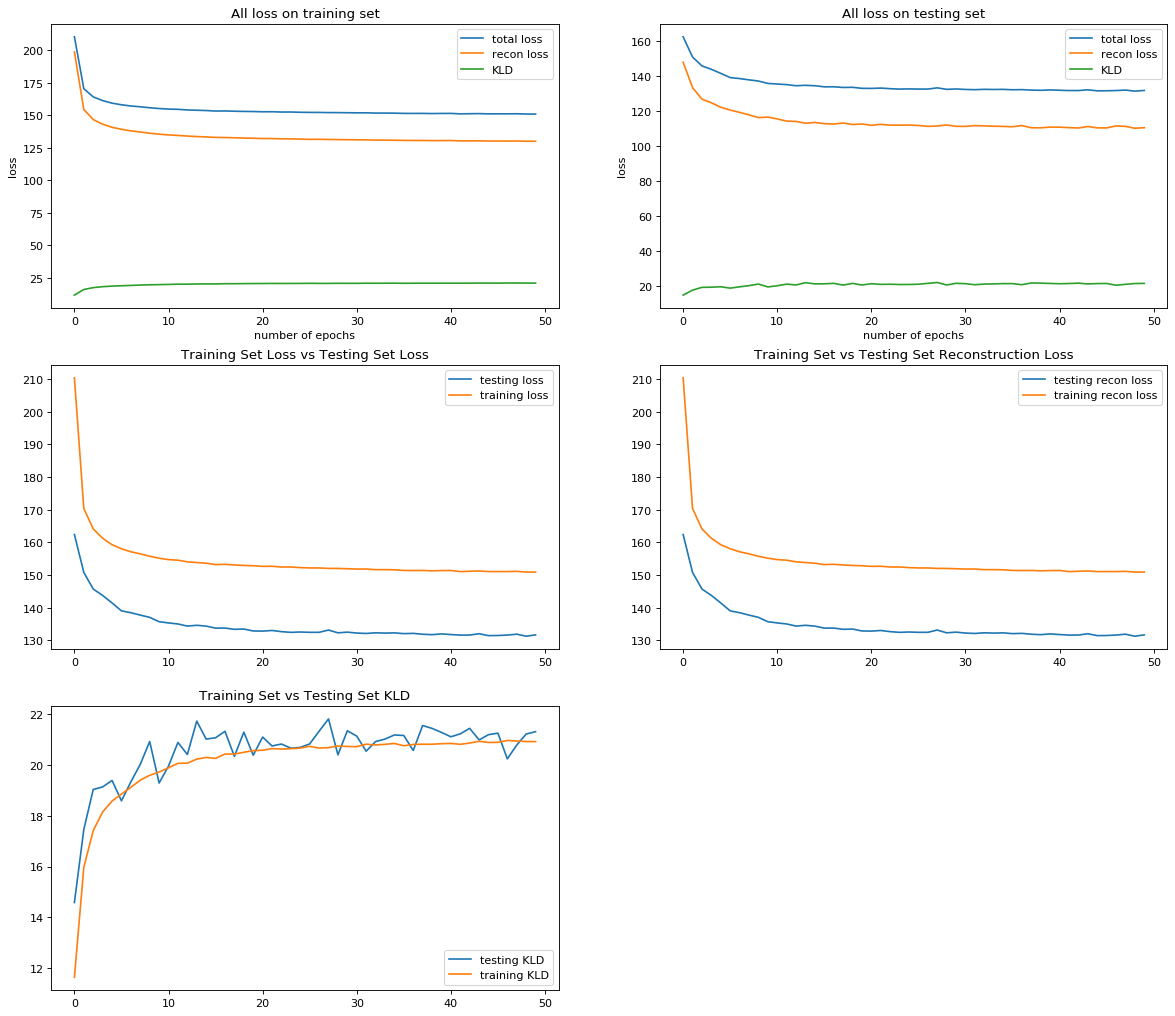

In [ ]:
# *CODE FOR PART 1.2a IN THIS CELL*
# According to the question we treat the test set as the validation set and evaluate it after every epoch
x = list(range(num_epochs))

plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
# First we plot the total loss, the reconstruction loss, and the kld for the trainging set
plt.subplot(3,2,1)
plt.plot(x, train_loss['loss'], label='total loss')
plt.plot(x, train_loss['recon_loss'], label='recon loss')
plt.plot(x, train_loss['KLD'], label='KLD')
plt.legend()
plt.xlabel('number of epochs')
plt.ylabel('loss')
plt.title('All loss on training set')
# Now we plot all the loss functions for the testing set
plt.subplot(3,2,2)
plt.plot(x, test_loss['loss'], label='total loss')
plt.plot(x, test_loss['recon_loss'], label='recon loss')
plt.plot(x, test_loss['KLD'], label='KLD')
plt.legend()
plt.xlabel('number of epochs')
plt.ylabel('loss')
plt.title('All loss on testing set')

# Plot the training set total loss and the testing set total loss
plt.subplot(3,2,3)
plt.plot(x, test_loss['loss'], label='testing loss')
plt.plot(x, train_loss['loss'], label='training loss')
plt.legend()
plt.title('Training Set Loss vs Testing Set Loss')

# Plot the training set reconstruction loss vs the testing set reconstruction loss
plt.subplot(3,2,4)
plt.plot(x, test_loss['loss'], label='testing recon loss')
plt.plot(x, train_loss['loss'], label='training recon loss')
plt.legend()
plt.title('Training Set vs Testing Set Reconstruction Loss')

# Plot the training set vs testing set KLD
plt.subplot(3,2,5)
plt.plot(x, test_loss['KLD'], label='testing KLD')
plt.plot(x, train_loss['KLD'], label='training KLD')
plt.legend()
plt.title('Training Set vs Testing Set KLD')

plt.show()

### Your answer to 1.2b here:

## Answer
During training, the log-likelihood loss decreases quite steadily while the KL divergence increases over training. The KL divergence term restricts the latent space to the prior assumed distribution, however during training the latent space still tends to re-distribute towards a distribution that better represents the training data. Thus over time KL divergence increases to a certain level and reaches equilibrium with the binary cross entropy loss.
This shows a tradeoff between maximizing the log likelihood(log-likehood loss) and staying close the the prior(KL divergence). This tradeoff occurrs to ensure to overall loss (binary cross entropy loss + KLD) still decreases over training. Also we can see that the training loss and testing loss behaves similarly over training, which indicates a good generalization of the trained results.

When doing the coursework I observed that some architectures are prone to posterior collapse, specifically when I implemented convolutional VAE it collapses very easily. In this coursework using a simple fully connected structure with the proper latent dimension does help the the mode collapse problem.

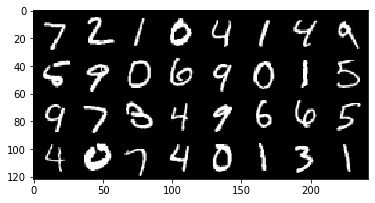

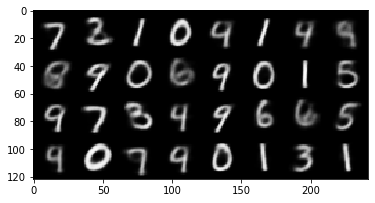

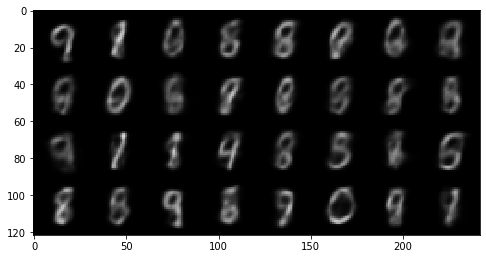

In [ ]:
# *CODE FOR PART 1.2c IN THIS CELL*

# load the model
model.load_state_dict(torch.load('./CW_VAE/MNIST/VAE_model.pth'))
sample_inputs, _ = next(iter(loader_test))
fixed_input = sample_inputs[0:32, :, :, :]

# visualize the original images of the last batch of the test set
img = make_grid(denorm(fixed_input), nrow=8, padding=2, normalize=False,
                range=None, scale_each=False, pad_value=0)
plt.figure()
show(img)

with torch.no_grad():
    # visualize the reconstructed images of the last batch of test set
    
    #######################################################################
    #                       ** START OF YOUR CODE **
    #######################################################################
    recon_batch,_,_ = model(fixed_input.to(device))
    #######################################################################
    #                       ** END OF YOUR CODE **
    ####################################################################### 
    
    recon_batch = recon_batch.cpu()
    recon_batch = make_grid(denorm(recon_batch), nrow=8, padding=2, normalize=False,
                            range=None, scale_each=False, pad_value=0)
    plt.figure()
    show(recon_batch)
    
model.eval()
n_samples = 32
z = torch.randn(n_samples,latent_dim).to(device)
with torch.no_grad():
    #######################################################################
    #                       ** START OF YOUR CODE **
    #######################################################################
    samples = model.decode(z)
    #######################################################################
    #                       ** END OF YOUR CODE **
    ####################################################################### 
    
    samples = samples.cpu()
    samples = make_grid(denorm(samples), nrow=8, padding=2, normalize=False,
                            range=None, scale_each=False, pad_value=0)
    plt.figure(figsize = (8,8))
    show(samples)



## Part 1.3 (15 points)

### Qualitative analysis of the learned representations

In this question you are asked to qualitatively assess the representations that your model has learned. In particular:

a. Extract the latent representations of the test set and visualize them using T-SNE (https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding, https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) or PCA. What do you observe? Discuss the structure of the visualized representations. Please use different colours for each digit class.

b. Perform a linear interpolation in the latent space of the autoencoder by choosing any two digits from the test set. What do you observe regarding the transition from on digit to the other?

In [ ]:
# *CODE FOR PART 1.3a IN THIS CELL*
model.eval()
latent_feats = np.empty((0,latent_dim))
labels = np.empty(0)
with torch.no_grad():
  for img, label in loader_test:
    mu, logvar = model.encode(img.to(device))
    latent_feat = model.reparametrize(mu, logvar)
    latent_feats = np.vstack([latent_feats, latent_feat.cpu().detach().numpy()])
    labels = np.hstack([labels, label.numpy()])

from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(latent_feats)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.081s...
[t-SNE] Computed neighbors for 10000 samples in 4.494s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 1.133386
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.587387
[t-SNE] KL divergence after 300 iterations: 2.642233


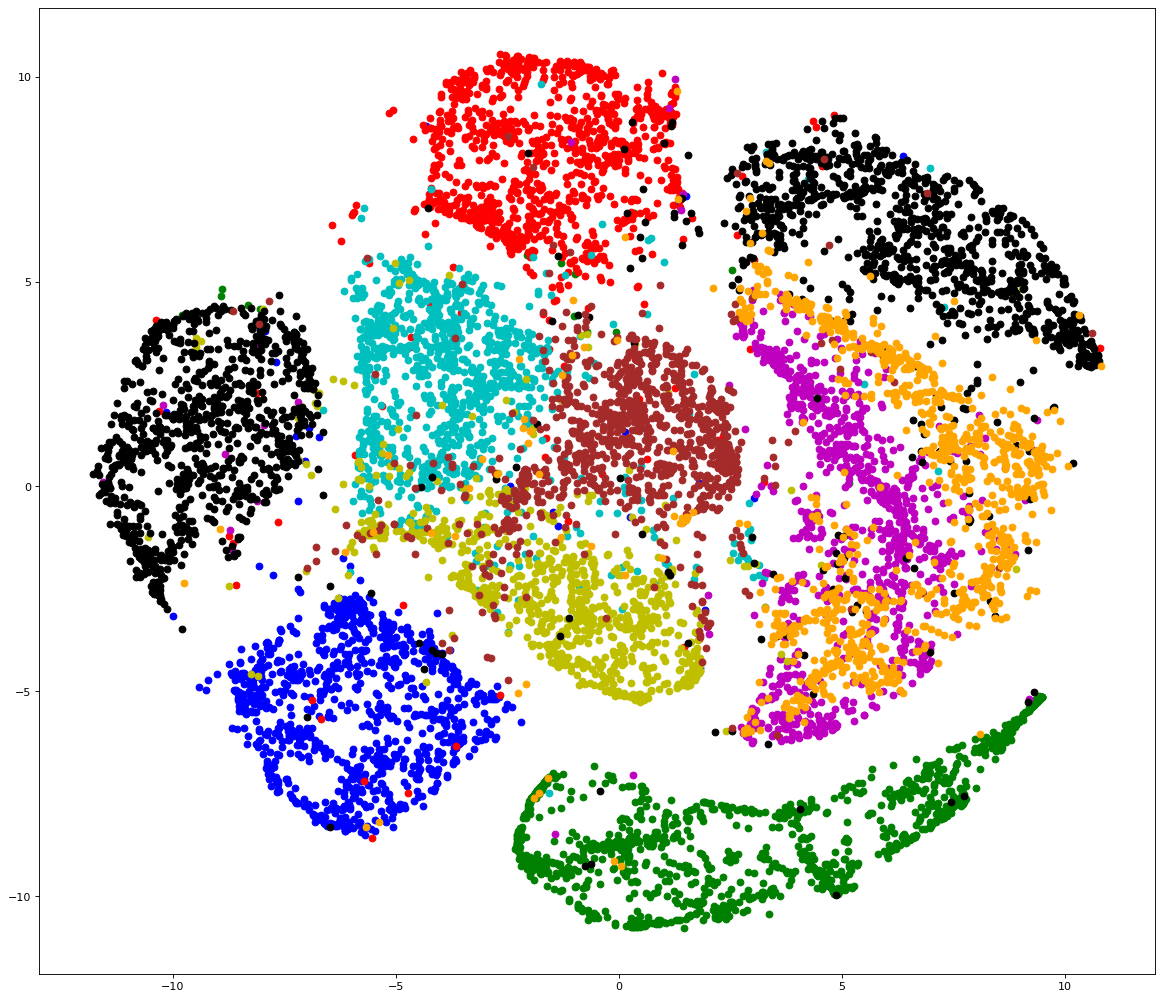

In [ ]:
plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
colors = ['b','g','r','c','m','y','k','black','brown','orange']
for i, c in enumerate(colors):
  plt.scatter(tsne_results[labels == i,0], tsne_results[labels == i,1], label = str(i), c = c)
#plt.scatter(tsne_results[:,0], tsne_results[:,1], label = labels, cmap='twilight')
plt.legend()
plt.show()

### Your answer to 1.3a here:

Looking at the above graph we see that the data with the same label are grouped together in the latent space, between each class there is an observable separation. However, since we tried to minimize the KL divergence of the latent distribution and the prior (Normal distribution) during training, each distributions are still close to each other, thus a latent feature sampled from our prior distribution is likely to be close the the actual encoded latent feature and would result in a better reconstructed image.

In [ ]:
# Create a image dictionary for performing interpolation
image_dict = {label:None for label in range(10)}
with torch.no_grad():
  for img_batch,label_batch in loader_test:
    # For simplicity we only consider the first element in each batch
    img, label = (img_batch[0], label_batch[0])
    if image_dict[int(label)] is None:
      # Assign a the image
      image_dict[int(label)] = img
# Check that each entry in image_dict is assigned
for i in range(10):
  if image_dict[i] is None:
    print('Images for label {} has not been assigned'.format(i))

torch.Size([12, 1, 28, 28])
torch.Size([12, 1, 28, 28])
torch.Size([12, 1, 28, 28])
torch.Size([12, 1, 28, 28])
torch.Size([12, 1, 28, 28])
torch.Size([12, 1, 28, 28])
torch.Size([12, 1, 28, 28])
torch.Size([12, 1, 28, 28])
torch.Size([12, 1, 28, 28])


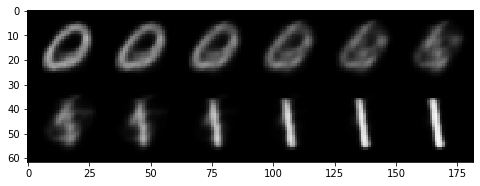

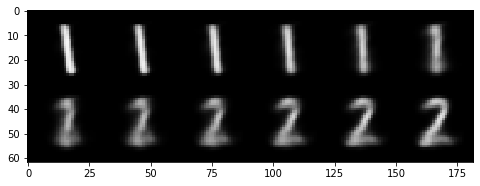

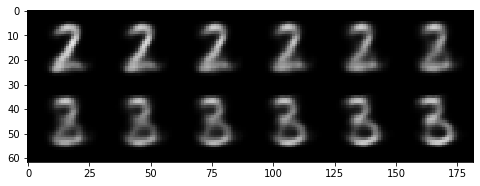

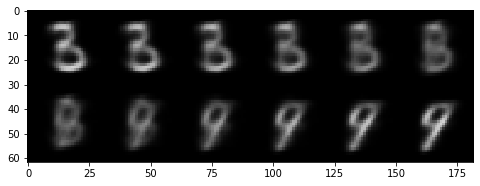

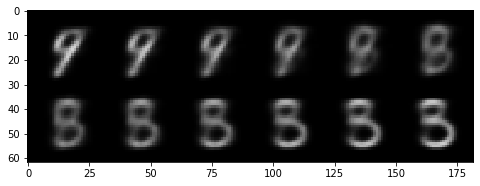

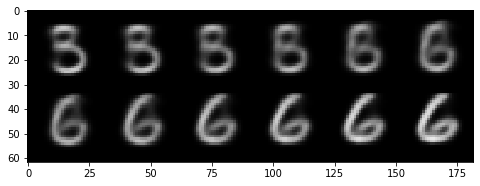

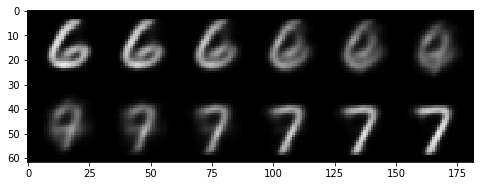

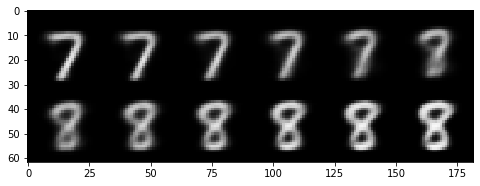

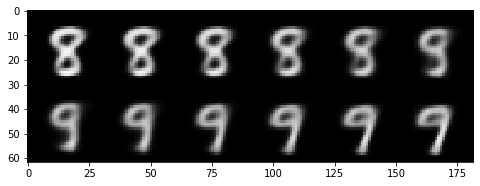

In [ ]:
def interpolate(model, image_dict, num1 = 0, num2 = 9):
    model.eval()
    with torch.no_grad():
      latent_feat2,_ = model.encode(image_dict[num1].view(-1, 1, 28, 28).to(device))
      latent_feat1,_ = model.encode(image_dict[num2].view(-1, 1, 28, 28).to(device)) #Since we are evaluating we only want the mean from the encoder
      
      latent_feats = torch.tensor([]).to(device)
      alpha_vals = np.linspace(0,1,12)
      for i, alpha_val in enumerate(alpha_vals):
        latent_feat_inter = alpha_val*latent_feat1 + (1-alpha_val)*latent_feat2
        latent_feats = torch.cat((latent_feats,latent_feat_inter), 0)
      samples = model.decode(latent_feats)
      # show the samples
      print(samples.shape)
      samples = samples.cpu()
      samples = make_grid(denorm(samples), nrow=6, padding=2, normalize=False,
                              range=None, scale_each=False, pad_value=0)
      plt.figure(figsize = (8,8))
      show(samples)

for i in range(9):
  interpolate(model, image_dict, num1 = i, num2 = i+1)

### Your answer to 1.3b here:
In the cell above we present the transformation of decoded images across an interpolation of features. We can see that the image slowly transforms from one digit to another. When we are closer to the middle of the interpolation the image becomes blurry and doesn't represent any digit. This is probably because when we are traveling from one label's distribution to the other, we travel through a space where no latent features occurred when encoding the training set. Thus the representation is not learned well enough to produce good quality images.

## Part 2 - Deep Convolutional GAN

In this task, your main objective is to train a DCGAN (https://arxiv.org/abs/1511.06434) on the CIFAR-10 dataset. You should experiment with different architectures, tricks for stability in training (such as using different activation functions, batch normalization, different values for the hyper-parameters, etc.). In the end, you should provide us with: 

- your best trained model (which we will be able to run), 
- some generations for the fixed latent vectors $\mathbf{z}\sim \mathcal{N}\left(\mathbf{0}, \mathbf{I}\right)$ we have provided you with (train for a number of epochs and make sure there is no mode collapse), 
- plots with the losses for the discriminator $D$ and the generator $G$ as the training progresses and explain whether your produced plots are theoretically sensible and why this is (or not) the case. 
- a discussion on whether you noticed any mode collapse, where this behaviour may be attributed to, and explain what you did in order to cope with mode collapse. 

_Clarification: You should not be worrying too much about getting an "optimal" performance on your trained GAN. We want you to demonstrate to us that you experimented with different types of DCGAN variations, report what difficulties transpired throughout the training process, etc. In other words, if we see that you provided us with a running implementation, that you detail different experimentations that you did before providing us with your best one, and that you have grapsed the concepts, you can still get full marks. The attached model does not have to be perfect._

### Part 2.1 (30 points)
**Your Task**: 

a. Implement the DCGAN architecture. Fill in the missing parts in the cells below in order to complete the Generator and Discriminator classes. You will need to define:

- The hyperparameters
- The constructors
- `decode`
- `discriminator`

b. visualize images sampled from your best model's generator.

c. Discuss the experimentations which led to your final architecture. You can plot losses or generated results by other architectures that you tested to back your arguments (but this is not necessary to get full marks).

For b. the code is already given. Make sure that the version of the notebook you deliver includes these results. 

Recomendations for experimentation:
- use the architecture that you implemented for the Autoencoder of Part 1 (encoder as discriminator, decoder as generator).
- use the architecture desribed in the DCGAN paper (https://arxiv.org/abs/1511.06434).

Some general reccomendations:
- add several convolutional layers (3-4).
- accelerate training with batch normalization after every convolutional layer.
- use the appropriate activation functions. 
- Generator module: the upsampling can be done with various methods, such as nearest neighbor upsampling (`torch.nn.Upsample`) or transposed convolutions(`torch.nn.ConvTranspose2d`). 
- Discriminator module: Experiment with batch normalization (`torch.nn.BatchNorm2d`) and leaky relu (`torch.nn.LeakyReLu`) units after each convolutional layer.

Try to follow the common practices for CNNs (e.g small receptive fields, max pooling, RELU activations), in order to narrow down your possible choices.

The number of epochs that will be needed in order to train the network will vary depending on your choices. As an advice, we recommend that while experimenting you should allow around 20 epochs and if the loss doesn't sufficiently drop, restart the training with a more powerful architecture. You don't need to train the network to an extreme if you don't have the time.

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
import torch.nn.functional as F
import matplotlib.pyplot as plt


def denorm(x, channels=None, w=None ,h=None, resize = False):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    if resize:
        if channels is None or w is None or h is None:
            print('Number of channels, width and height must be provided for resize.')
        x = x.view(x.size(0), channels, w, h)
    return x

def show(img):
    if torch.cuda.is_available():
        img = img.cpu()
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))

# device selection
GPU = True
device_idx = 0
if GPU:
    device = torch.device("cuda:" + str(device_idx) if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
print(device)

# We set a random seed to ensure that your results are reproducible.
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
torch.manual_seed(0)

if not os.path.exists('./CW_DCGAN'):
    os.makedirs('./CW_DCGAN')

cuda:0


### Data loading

In [ ]:
batch_size = 64  # change that
NUM_TRAIN = 49000

transform = transforms.Compose([
     transforms.Resize(64), #Resize to 64x64 image according to the original DCGAN paper
     transforms.ToTensor(),
     transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])


data_dir = './datasets'

cifar10_train = datasets.CIFAR10(data_dir, train=True, download=True,
                             transform=transform)
cifar10_val = datasets.CIFAR10(data_dir, train=True, download=True,
                           transform=transform)
cifar10_test = datasets.CIFAR10(data_dir, train=False, download=True, 
                            transform=transform)

loader_train = DataLoader(cifar10_train, batch_size=batch_size, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))
loader_val = DataLoader(cifar10_val, batch_size=batch_size, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))
loader_test = DataLoader(cifar10_test, batch_size=batch_size)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


### Hyper-parameter selection

In [ ]:
# *CODE FOR PART 2.1 IN THIS CELL*

### Choose the number of epochs, the learning rate
#   and the size of the Generator's input noise vetor.
num_epochs = 30
learning_rate  = 1e-3
latent_vector_size = 100
###

# Define here other hyperparameters that you used.

In [ ]:
sample_inputs, _ = next(iter(loader_test))
fixed_input = sample_inputs[:32, :, :, :]
fixed_input.shape

torch.Size([32, 3, 64, 64])

In [ ]:
# *CODE FOR PART 2.1 IN THIS CELL*


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        '''
        self.conv_decode = nn.Sequential(
            nn.ConvTranspose2d(latent_vector_size, 1024, 4, stride=2, padding=0),
            nn.BatchNorm2d(1024),
            nn.ReLU(),

            nn.ConvTranspose2d(1024, 512, 5, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.ConvTranspose2d(512, 256, 5, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.ConvTranspose2d(256, 128, 5, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 64, 5, stride=1, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            nn.Conv2d(64, 3, 4, stride=1, padding=0),
            nn.BatchNorm2d(3),
            nn.Tanh(),
        )
        '''
        self.conv_decode = nn.Sequential(
            nn.ConvTranspose2d(latent_vector_size, 512, 4, 1, 0),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 4, 2, 1),
            nn.Tanh()
        )
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 

    def decode(self, z):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        shape = z.shape
        #z = z.view(shape[0], -1, 1, 1)
        x = self.conv_decode(z)
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 
        return x

    def forward(self, z):
        return self.decode(z)


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        
        
        self.conv_encode = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 
        
    def discriminator(self, x):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        out = self.conv_encode(x)
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 
        
        return out

    def forward(self, x):
        outs = self.discriminator(x)
        return outs.view(-1, 1).squeeze(1)

### Initialize Model and print number of parameters

You can use method `weights_init` to initialize the weights of the Generator and Discriminator networks. Otherwise, implement your own initialization, or do not use at all. You will not be penalized for not using initialization.

In [ ]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [ ]:
use_weights_init = True

model_G = Generator().to(device)
if use_weights_init:
    model_G.apply(weights_init)
params_G = sum(p.numel() for p in model_G.parameters() if p.requires_grad)
print("Total number of parameters in Generator is: {}".format(params_G))
print(model_G)
print('\n')

model_D = Discriminator().to(device)
if use_weights_init:
    model_D.apply(weights_init)
params_D = sum(p.numel() for p in model_D.parameters() if p.requires_grad)
print("Total number of parameters in Discriminator is: {}".format(params_D))
print(model_D)
print('\n')

print("Total number of parameters is: {}".format(params_G + params_D))

Total number of parameters in Generator is: 3577667
Generator(
  (conv_decode): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (13): Tanh()
  )
)


Total number of parameters in Discriminator is:

### Define loss function

In [ ]:
criterion = nn.BCELoss(reduction='mean')
def loss_function(out, label):
    loss = criterion(out, label)
    return loss

### Choose and initialize optimizers

In [ ]:
# setup optimizer
# You are free to add a scheduler or change the optimizer if you want. We chose one for you for simplicity.
beta1 = 0.5
optimizerD = torch.optim.Adam(model_D.parameters(), lr=learning_rate, betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(model_G.parameters(), lr=learning_rate, betas=(beta1, 0.999))

### Define fixed input vectors to monitor training and mode collapse.

In [ ]:
fixed_noise = torch.randn(batch_size, latent_vector_size, 1, 1, device=device)
real_label = 1
fake_label = 0

### Train

In [ ]:
train_losses_G = []
train_losses_D = []

for epoch in range(num_epochs):
    train_loss_D = 0
    train_loss_G = 0
    for i, data in enumerate(loader_train, 0):
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################device
        # train with real
        model_D.zero_grad()
        real_cpu = data[0].to(device)
        batch_size = real_cpu.size(0)
        label = torch.full((batch_size,), real_label, device=device)

        output = model_D(real_cpu)
        errD_real = loss_function(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # train with fake
        noise = torch.randn(batch_size, latent_vector_size, 1, 1, device=device)
        fake = model_G(noise)
        label.fill_(fake_label)
        output = model_D(fake.detach())
        errD_fake = loss_function(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        train_loss_D += errD.item()
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        model_G.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        output = model_D(fake)
        errG = loss_function(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        train_loss_G += errG.item()
        optimizerG.step()

        print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
              % (epoch, num_epochs, i, len(loader_train),
                 errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

    if epoch == 0:
        save_image(denorm(real_cpu.cpu()).float(), './CW_DCGAN/real_samples.png')
    
    fake = model_G(fixed_noise)
    save_image(denorm(fake.cpu()).float(), './CW_DCGAN/fake_samples_epoch_%03d.png' % epoch)
    train_losses_D.append(train_loss_D / len(loader_train))
    train_losses_G.append(train_loss_G / len(loader_train))
            
# save losses and models
torch.save(model_G.state_dict(), './CW_DCGAN/DCGAN_model_G.pth')
torch.save(model_D.state_dict(), './CW_DCGAN/DCGAN_model_D.pth')

Streaming output truncated to the last 5000 lines.
[23/30][363/766] Loss_D: 0.3302 Loss_G: 3.5319 D(x): 0.9358 D(G(z)): 0.1854 / 0.0489
[23/30][364/766] Loss_D: 1.1078 Loss_G: 7.8583 D(x): 0.9485 D(G(z)): 0.5053 / 0.0007
[23/30][365/766] Loss_D: 2.0009 Loss_G: 1.5917 D(x): 0.2263 D(G(z)): 0.0206 / 0.3597
[23/30][366/766] Loss_D: 1.3427 Loss_G: 5.5070 D(x): 0.9533 D(G(z)): 0.5576 / 0.0108
[23/30][367/766] Loss_D: 0.4222 Loss_G: 4.1168 D(x): 0.7893 D(G(z)): 0.1100 / 0.0299
[23/30][368/766] Loss_D: 0.8859 Loss_G: 1.6523 D(x): 0.6090 D(G(z)): 0.1374 / 0.3108
[23/30][369/766] Loss_D: 0.8492 Loss_G: 6.0112 D(x): 0.9726 D(G(z)): 0.4624 / 0.0041
[23/30][370/766] Loss_D: 0.9954 Loss_G: 2.1067 D(x): 0.5523 D(G(z)): 0.0732 / 0.2064
[23/30][371/766] Loss_D: 0.3446 Loss_G: 3.8034 D(x): 0.9559 D(G(z)): 0.2125 / 0.0424
[23/30][372/766] Loss_D: 0.4234 Loss_G: 4.4357 D(x): 0.8924 D(G(z)): 0.2053 / 0.0207
[23/30][373/766] Loss_D: 0.3625 Loss_G: 4.3783 D(x): 0.8759 D(G(z)): 0.1394 / 0.0224
[23/30][374/76

In [ ]:
# DISCUSS THE SELECTION OF THE ARCHITECTURE IN THIS CELL*


### Generator samples

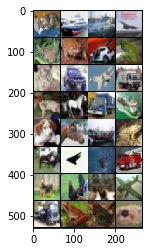

In [ ]:
it = iter(loader_test)
sample_inputs, _ = next(it)
fixed_input = sample_inputs[0:32, :, :, :]

# visualize the original images of the last batch of the test set
img = make_grid(denorm(fixed_input), nrow=4, padding=2, normalize=False,
                range=None, scale_each=False, pad_value=0)
show(img)

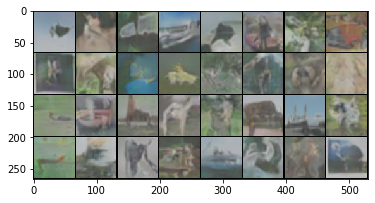

In [ ]:
# load the model
model_G.load_state_dict(torch.load('./CW_DCGAN/DCGAN_model_G.pth'))
input_noise = torch.randn(batch_size, latent_vector_size, 1, 1, device=device)

with torch.no_grad():
    # visualize the generated images
    generated = model_G(input_noise).cpu()
    generated = make_grid(denorm(generated)[:32], nrow=8, padding=2, normalize=False, 
                        range=None, scale_each=False, pad_value=0)
    show(generated)

### Part 2.2 (10 points)

### Train losses curves
**Your task:**


Plot the losses curves for the discriminator $D$ and the generator $G$ as the training progresses and explain whether the produced curves are theoretically sensible and why this is (or not) the case (x-axis: epochs, y-axis: loss).

The code for generating the plot is already given. Make sure that the version of the notebook you deliver includes these results.

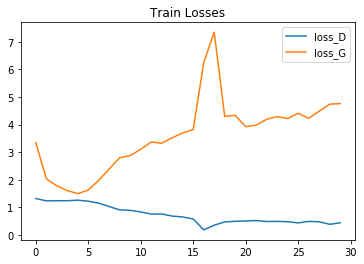

In [ ]:
import matplotlib.pyplot as plt
plt.plot(list(range(0, np.array(train_losses_D).shape[0])), np.array(train_losses_D), label='loss_D')
plt.plot(list(range(0, np.array(train_losses_G).shape[0])), np.array(train_losses_G), label='loss_G')
plt.legend()
plt.title('Train Losses')
plt.show()

In [ ]:
# ANSWER FOR PART 2.2 IN THIS CELL*


From the above plot we see that the discriminator loss goes to about 0.5 after some trainging has happened. The generator, on the other hand, has a much larger loss, reaching about 5 after 30 epochs and seems to be keep increasing. The fact that the generator loss is larger than the discriminator loss is normal in usual GAN training. The discriminator loss also went to a desired value (close to 0.5), but the generator has a much larger loss than we would have hoped (ideally about 1.5). The desired value of the loss are based on the article: [How to Identify and Diagnose GAN Failure Modes](https://machinelearningmastery.com/practical-guide-to-gan-failure-modes/).

Although the convergence isn't perfect, the model does generate image like objects after 30 epochs of training. When I tried using a different architecture or discarding batch normalization, often times what happened is that the discriminator loss goes to zero and the generator loss spikes up to a very large value. The model then never generates image like outputs. After employing the architecture provided in the DCGAN paper for the generator, and also rescaling the image to (64, 64), I obtained a much stabler trainging process. However, when I train for more epochs (say 50), the model may generate good images at first but suddenly dies out and start generating 'garbage' images, thus the trainging process still has a probability of failing to converge to the equilibrium we desired.

We may need to train on more epochs to see the overall convergence of the model. 

### Part 2.3 (10 points) 
**Your task:** 

Based on the images created by your generator using the `fixed_noise` vector during training, provide a discussion on whether you noticed any mode collapse, where this behaviour may be attributed to, and explain what you did in order to cope with mode collapse.

In [ ]:
# ANSWER FOR PART 2.3 IN THIS CELL*


When looking at the generated image we can see a slight trace of mode collapse, though not obvious. For example, the background for most of the generated images appears to be green, also some of the images looks suspectingly similar. Mode collapse happens when the generator maps different inputs to the same specific distribution. This could happen when the architecture of the generator or discriminator doesn't have enough capacity, or that the input itself(latent feature) has too little dimension. Intuitively we can describe what happens as the generator learns a way to trick the discriminator easily, thus keeps outputing similar images to trick the discriminator instead of really learning the full distribution. To cope with mode collapse we could try to tune the architecture of the GAN. For example, increase the latent feature's dimension, or enhance the capacity of the generator or the discriminator.